In [10]:
import os
import numpy as np
import pandas as pd
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import warnings
import folium
from tqdm import tqdm
from folium.plugins import MarkerCluster
from yellowbrick.cluster import KElbowVisualizer
from branca.colormap import LinearColormap
from IPython.display import display
from joblib import Parallel, delayed

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set environment variable for OpenMP
os.environ['OMP_NUM_THREADS'] = '1'

In [11]:
# Load the dataset
data = pd.read_excel("Dataset.xlsx")

row_count = data.shape[0]
print("Number of rows:", row_count)

print("\n", data.head(5))

# Extract coordinates and variables
X, Y = data['Longitude'].values, data['Latitude'].values
Z = data['LungCancerRate'].values
Z_positive = np.where(Z == 0, 0.01, Z)
Z_log = np.log1p(Z_positive)

# Prepare additional variables
additional_vars = ['Smoking', 'Poverty', 'PM 2.5', 'Insurance', 'Income']
additional_data = data[additional_vars].values

# Split the data
train_data, test_data = train_test_split(np.column_stack((X, Y, Z_log, additional_data)), test_size=0.2, random_state=42)

Number of rows: 3143

    FIPS   Parish   Latitude  Longitude    Income  Insurance    PM 2.5  \
0  1001  Autauga  32.535142 -86.642900  0.308876   0.828652  0.619048   
1  1003  Baldwin  30.727825 -87.722745  0.343421   0.772472  0.455782   
2  1005  Barbour  31.870090 -85.391068  0.151268   0.719101  0.578231   
3  1007     Bibb  32.998376 -87.126814  0.231939   0.755618  0.605442   
4  1009   Blount  33.980871 -86.567006  0.251355   0.707865  0.591837   

    Poverty   Smoking  LungCancerRate  
0  0.161165  0.424242        0.311271  
1  0.135922  0.478788        0.288991  
2  0.403883  0.515152        0.338794  
3  0.316505  0.590909        0.412844  
4  0.198058  0.578788        0.333552  


In [12]:
# Perform UniversalKriging
def perform_kriging(x, y):
    try:
        pred, _ = uk_model.execute('points', np.array([x]), np.array([y]))
        return pred[0]
    except Exception as e:
        print(f"Error at point ({x}, {y}): {str(e)}")
        return np.nan

print("Performing UniversalKriging...")
uk_model = UniversalKriging(train_data[:, 0], train_data[:, 1], train_data[:, 2], variogram_model='spherical', drift_terms=['regional_linear'])

# Use parallel processing for kriging
uk_all_predictions = Parallel(n_jobs=-1)(delayed(perform_kriging)(x, y) for x, y in tqdm(zip(X, Y), total=len(X), desc="UK Progress"))
uk_all_predictions = np.array(uk_all_predictions)
print("UniversalKriging completed.")

# Convert predictions back to original scale and add to DataFrame
data['UK_Predicted_LungCancerRate'] = np.expm1(uk_all_predictions)

Performing UniversalKriging...


UK Progress: 100%|█████████████████████████████████████████████████████████████████| 3143/3143 [28:46<00:00,  1.82it/s]


UniversalKriging completed.


In [13]:
# Calculate error metrics
uk_mae = mean_absolute_error(data['LungCancerRate'], data['UK_Predicted_LungCancerRate'])
uk_r2 = r2_score(data['LungCancerRate'], data['UK_Predicted_LungCancerRate'])

# Display error metrics
print(f"Universal Kriging - MAE: {uk_mae:.4f}")
print(f"Universal Kriging - R-squared: {uk_r2:.4f}")

Universal Kriging - MAE: 0.0117
Universal Kriging - R-squared: 0.8981


In [14]:
# Main execution
feature_column = 'UK_Predicted_LungCancerRate'
feature_name = 'Predicted Lung Cancer Rate'

Optimal K for clustering:  6


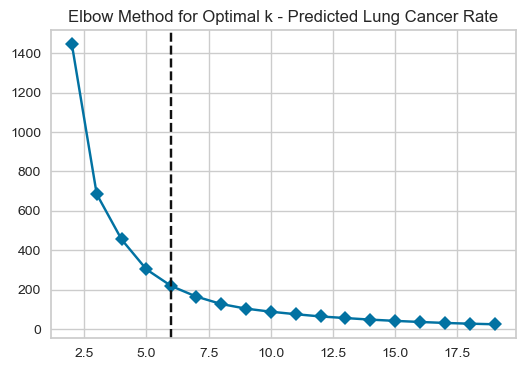

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

def perform_clustering(data, feature_column, feature_name):
    features = data[[feature_column]].values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Elbow method for optimal k
    plt.figure(figsize=(6, 4))
    visualizer = KElbowVisualizer(KMeans(n_init=10, random_state=42), k=(2, 20), metric='distortion', timings=False)
    visualizer.fit(features_scaled)
    
    # Add title to the plot
    plt.title(f"Elbow Method for Optimal k - {feature_name}", fontsize=12)
    
    optimal_k = visualizer.elbow_value_
    
    print("Optimal K for clustering: ", optimal_k)
    
    # Display the plot
    plt.show()
    
    # Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    return optimal_k, cluster_labels

# Perform clustering
optimal_k, cluster_labels = perform_clustering(data, feature_column, feature_name)

In [22]:
def create_cluster_map(data, feature_column, feature_name, cluster_labels):
    data[f'Cluster_{feature_name}'] = cluster_labels
    optimal_k = len(np.unique(cluster_labels))
    
    m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=4)
    cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'brown', 'magenta']
    color_dict = {i: cluster_colors[i % len(cluster_colors)] for i in range(optimal_k)}
    
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=f"Parish: {row['Parish']}<br>Cluster: {row[f'Cluster_{feature_name}']}<br>{feature_name}: {row[feature_column]:.3f}<br>",
            color=color_dict[row[f'Cluster_{feature_name}']],
            fill=True,
            fillColor=color_dict[row[f'Cluster_{feature_name}']],
            fillOpacity=0.7,
            weight=2
        ).add_to(m)
    
    # Add color scale legend for clusters
    legend_html = f'''
        <div style="position: fixed; bottom: 30px; left: 30px; width: 120px; height: 200px;
        border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
        ">&nbsp; Cluster Legend ({feature_name}) <br>
    '''
    for i in range(optimal_k):
        legend_html += f'&nbsp; <i class="fa fa-circle fa-1x" style="color:{color_dict[i]}"></i> Cluster {i}<br>'
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    display(m)
    
# Create and display the cluster map
create_cluster_map(data, feature_column, feature_name, cluster_labels)

In [17]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

def cluster_wise_analysis(data, feature_name, optimal_k, additional_vars):
    for cluster in range(optimal_k):
        cluster_data = data[data[f'Cluster_{feature_name}'] == cluster]
        n_obs = len(cluster_data)
        
        if n_obs < 10:
            print(f"\nCluster {cluster} has too few points, skipping...")
            continue
        
        print(f"\nCluster {cluster} - Number of observations: {n_obs}")
        
        # Prepare the design matrix
        Z_cluster = np.log1p(cluster_data['UK_Predicted_LungCancerRate'].values)
        X_additional = cluster_data[additional_vars].values
        X_additional_scaled = StandardScaler().fit_transform(X_additional)
        X_with_drift = np.column_stack((np.ones(n_obs), X_additional_scaled))
        
        # Perform calculations
        mse = np.mean((Z_cluster - np.mean(Z_cluster))**2) 
        p = X_with_drift.shape[1]
        dof = n_obs - p
        
        # Covariance matrix calculation
        cov_matrix = np.linalg.inv(X_with_drift.T @ X_with_drift + np.eye(p) * 1e-8) * mse
        std_errors = np.sqrt(np.diag(cov_matrix))
        
        # Coefficients
        coefficients = np.linalg.lstsq(X_with_drift, Z_cluster, rcond=None)[0] 
        
        # T-statistics and P-values calculation
        t_stats = coefficients / std_errors
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=dof))
        std_coefficients = coefficients[1:] * np.std(X_with_drift[:, 1:], axis=0)
        
        # Print results
        print("\nVariable Statistics:")
        print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("Variable", "Coefficient", "Std Error", "T-stat", "P-value"))
        print("-" * 75)
        
        variable_names = ['Intercept'] + additional_vars
        for name, coef, std_err, t_stat, p_val in zip(variable_names, coefficients, std_errors, t_stats, p_values):
            print("{:<15} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(name, coef, std_err, t_stat, p_val))
        
        # Calculate and display average mean of each variable in the cluster
        print("\nAverage mean of variables in the cluster:")
        for var, mean_value in zip(additional_vars, X_additional.mean(axis=0)):
            print(f"{var}: {mean_value:.4f}")

# Perform cluster-wise analysis
cluster_wise_analysis(data, feature_name, optimal_k, additional_vars)


Cluster 0 - Number of observations: 646

Variable Statistics:
Variable        Coefficient     Std Error       T-stat          P-value        
---------------------------------------------------------------------------
Intercept       0.215361        0.000790        272.459527      0.000000       
Smoking         0.002484        0.001054        2.358058        0.018671       
Poverty         -0.002420       0.001136        -2.130457       0.033515       
PM 2.5          0.000811        0.000838        0.967203        0.333808       
Insurance       -0.000376       0.000906        -0.414784       0.678439       
Income          -0.001413       0.001293        -1.092707       0.274934       

Average mean of variables in the cluster:
Smoking: 0.3920
Poverty: 0.1617
PM 2.5: 0.4406
Insurance: 0.7711
Income: 0.3258

Cluster 1 - Number of observations: 568

Variable Statistics:
Variable        Coefficient     Std Error       T-stat          P-value        
-----------------------------------